In [1]:
# --- 1. Import Libraries ---
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
# --- 2. Load Data ---

train_df = pd.read_csv(r"D:\SEM 5\ML\Loan Approval Prediction  datasets\playground-series-s4e10\train.csv")
test_df = pd.read_csv(r"D:\SEM 5\ML\Loan Approval Prediction  datasets\playground-series-s4e10\test.csv")
sample_submission_df = pd.read_csv(r"D:\SEM 5\ML\Loan Approval Prediction  datasets\playground-series-s4e10\sample_submission.csv")
print("Data loaded successfully.")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Data loaded successfully.
Training data shape: (58645, 13)
Test data shape: (39098, 12)


In [3]:
# --- 3. Preprocessing and Feature Engineering ---

# Store test IDs for submission
test_ids = test_df['id']
# Drop the 'id' column as it's not a feature for training
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)


In [4]:
# Separate target variable
X = train_df.drop('loan_status', axis=1)
y = train_df['loan_status']

In [5]:
# Identify categorical features
# We will treat any column with dtype 'object' as categorical.
categorical_features = X.select_dtypes(include=['object']).columns

print(f"\nIdentified {len(categorical_features)} categorical features: {list(categorical_features)}")



Identified 4 categorical features: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [6]:
# Apply one-hot encoding
# This converts categorical variables into a format that can be provided to ML algorithms
X = pd.get_dummies(X, columns=categorical_features, dummy_na=False)
test_df = pd.get_dummies(test_df, columns=categorical_features, dummy_na=False)

In [7]:
# Align columns - This is a crucial step!
# It ensures that the test set has the exact same columns as the training set.
# Some categories might exist in train but not test, or vice-versa.
train_labels = X.columns
test_labels = test_df.columns

In [8]:
# Find columns that are in train but not in test and add them to test, filling with 0
missing_in_test = set(train_labels) - set(test_labels)
for c in missing_in_test:
    test_df[c] = 0

In [9]:
# Find columns that are in test but not in train and add them to train, filling with 0
missing_in_train = set(test_labels) - set(train_labels)
for c in missing_in_train:
    X[c] = 0

In [10]:
# Ensure the order of columns is the same
test_df = test_df[X.columns]

print("\nPreprocessing completed. Train and test columns are aligned.")
print(f"Shape of processed training data: {X.shape}")
print(f"Shape of processed test data: {test_df.shape}")



Preprocessing completed. Train and test columns are aligned.
Shape of processed training data: (58645, 26)
Shape of processed test data: (39098, 26)


In [11]:
# --- 4. Model Training (LightGBM with Cross-Validation) ---

# Define model parameters. These are good starting points.
# You can tune these for better performance.
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'num_leaves': 20,
    'max_depth': 5,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
}

In [12]:
# Using Stratified K-Fold Cross-Validation for more robust evaluation
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test_df))

print(f"\nStarting training with {N_SPLITS}-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    # Split data for this fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # Initialize and train the model
    model = lgb.LGBMClassifier(**params)
    
    # Use early stopping to find the optimal number of boosting rounds
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100, verbose=False)])
    
    # Predict on validation set (for Out-of-Fold score)
    val_preds = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_preds
    
    # Predict on the test set
    # We will average the predictions from each fold model
    test_preds += model.predict_proba(test_df)[:, 1] / N_SPLITS


Starting training with 5-Fold Cross-Validation...
--- Fold 1/5 ---
--- Fold 2/5 ---
--- Fold 3/5 ---
--- Fold 4/5 ---
--- Fold 5/5 ---


In [13]:
# Evaluate overall Out-of-Fold (OOF) AUC score
oof_auc = roc_auc_score(y, oof_preds)
print(f"\nTraining finished. Overall OOF AUC: {oof_auc:.5f}")


Training finished. Overall OOF AUC: 0.95806


In [14]:
# --- 5. Generate Submission File ---
submission_df = pd.DataFrame({'id': test_ids, 'loan_status': test_preds})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print(submission_df.head())


Submission file 'submission.csv' created successfully!
      id  loan_status
0  58645     0.989333
1  58646     0.019420
2  58647     0.575155
3  58648     0.011242
4  58649     0.082822


Loan Approval dataset loaded successfully.

Generating EDA plots for Loan Approval Dataset...


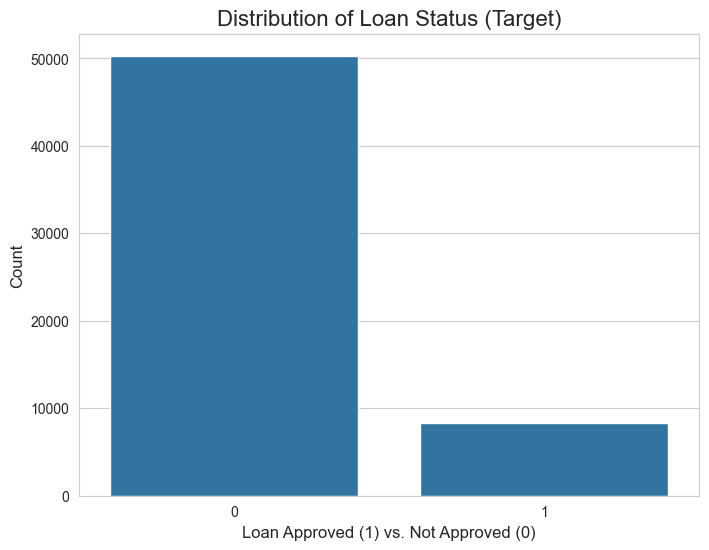


Please update the 'numerical_cols_loan' list with your actual column names.


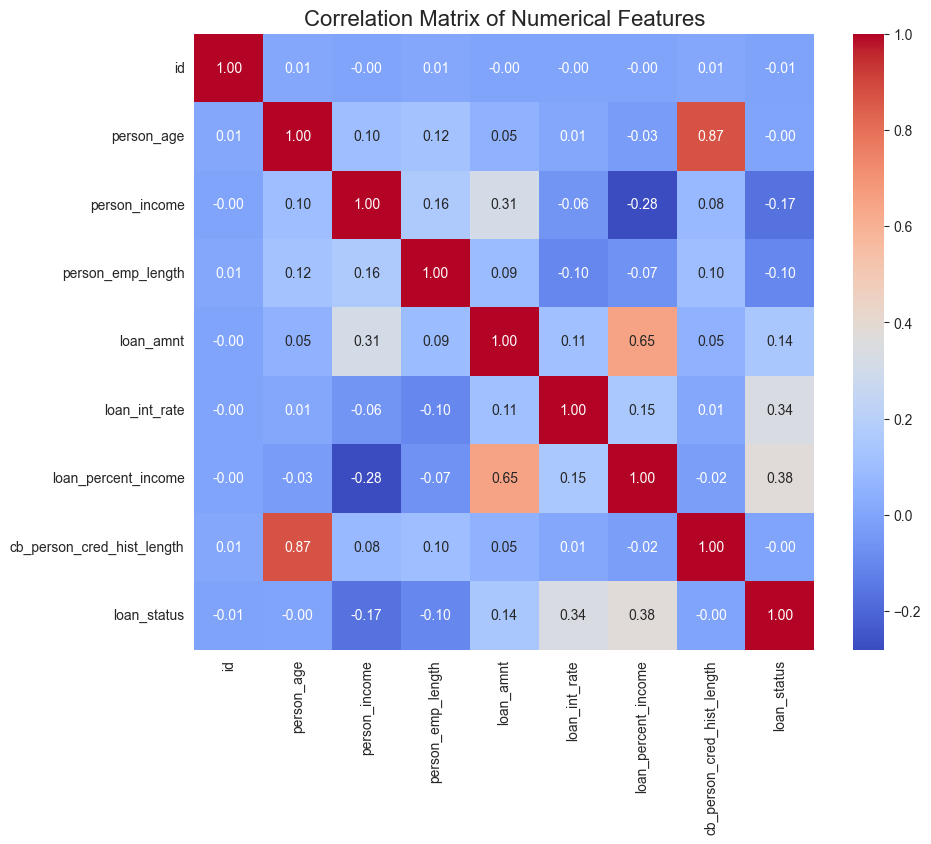


Training a model to get Feature Importance...
[LightGBM] [Info] Number of positive: 8350, number of negative: 50295
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 58645, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795644
[LightGBM] [Info] Start training from score -1.795644


<Figure size 1200x800 with 0 Axes>

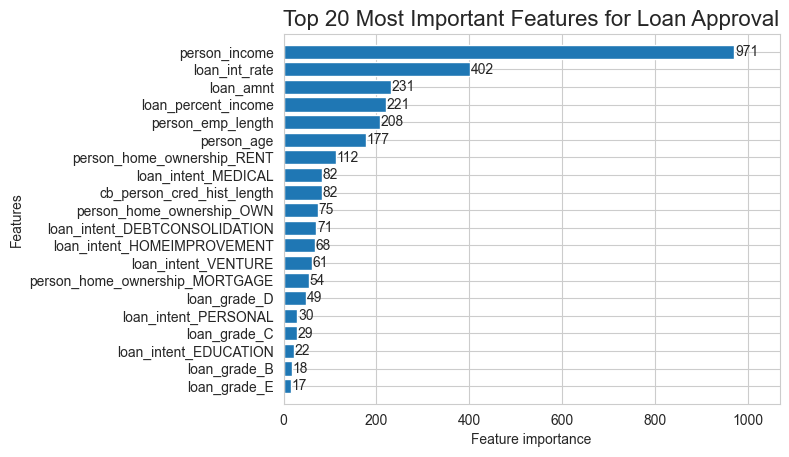

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

# --- 1. Load Data ---
# Ensure the 'train.csv' from the LOAN APPROVAL competition is in the same folder.
try:
    df_loan = pd.read_csv(r"D:\SEM 5\ML\Loan Approval Prediction  datasets\playground-series-s4e10\train.csv")
    print("Loan Approval dataset loaded successfully.")
except FileNotFoundError:
    print("FATAL ERROR: 'train.csv' not found. Please check the file location.")
    exit()

# Set plot style
sns.set_style("whitegrid")

# --- 2. Exploratory Data Analysis (EDA) ---
print("\nGenerating EDA plots for Loan Approval Dataset...")

# Plot 1: Target Variable Distribution (Loan Status)
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=df_loan)
plt.title('Distribution of Loan Status (Target)', fontsize=16)
plt.xlabel('Loan Approved (1) vs. Not Approved (0)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Plot 2: Distribution of Key Numerical Features
# ===> ACTION REQUIRED: UPDATE THE COLUMN NAMES IN THE LIST BELOW <===
# Replace these placeholders with the actual numerical column names from your dataset.
numerical_cols_loan = ['Annual_Income', 'Loan_Amount_Requested', 'Credit-Score'] # <--- CHANGE THESE NAMES

# This code now checks which columns exist before trying to plot them.
existing_cols = [col for col in numerical_cols_loan if col in df_loan.columns]

if existing_cols:
    print(f"Plotting histograms for: {existing_cols}")
    df_loan[existing_cols].hist(bins=30, figsize=(15, 5), layout=(1, len(existing_cols)))
    plt.suptitle('Distribution of Key Numerical Features', fontsize=16)
    plt.show()
else:
    print("\nWarning: None of the specified numerical columns were found in the DataFrame.")
    print("Please update the 'numerical_cols_loan' list with your actual column names.")


# Plot 3: Correlation Heatmap for Numerical Features
plt.figure(figsize=(10, 8))
numeric_only_df = df_loan.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_only_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()


# --- 3. Model Interpretation (Feature Importance) ---
print("\nTraining a model to get Feature Importance...")

# Basic preprocessing
X = df_loan.drop(['id', 'loan_status'], axis=1, errors='ignore')
y = df_loan['loan_status']
categorical_features = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_features, dummy_na=False)

# Train a simple LightGBM model
model = lgb.LGBMClassifier(random_state=42)
model.fit(X, y)

# Plot 4: Feature Importance
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=20, height=0.8)
plt.title('Top 20 Most Important Features for Loan Approval', fontsize=16)
plt.show()